# Self-Driving Car Engineer Capstone
## Traffic Light Detection

In [3]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
import pickle

In [88]:
def binary_to_3_channel_img(binary_img):
    new_img = np.dstack((binary_img, binary_img, binary_img)) * 255
    return new_img

def region_of_interest(img, vertices):
    """
    Applies an image mask.

    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    # defining a blank mask to start with
    mask = np.zeros_like(img)

    # defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    # filling pixels inside the polygon defined by "vertices" with the fill color
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    # returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def render_region_of_interest(img, vertices):
    for i in range(0, 4):
        x1, y1 = vertices[i]
        next_vertices = i + 1 if i < 3 else 0
        x2, y2 = vertices[next_vertices]
        cv2.line(img, (x1, y1), (x2, y2), color=(255, 0, 0), thickness=2)


def render_recognized_circles(image, circles, border_color=(0, 0, 0), center_color=(0, 0, 255)):
    for i in circles[0, :]:
        # draw the outer circle
        cv2.circle(image, (i[0], i[1]), i[2], border_color, 2)
        # draw the center of the circle
        #cv2.circle(image, (i[0], i[1]), 2, center_color, 3)


def recognize_light(image, lower_range, upper_range):
    ranged_image = cv2.inRange(image, lower_range, upper_range)
    return ranged_image


def get_hough_circles(weighted_img):
    blur_img = cv2.GaussianBlur(weighted_img, (15, 15), 0)
    canny_img = get_canny_edge(weighted_img)
    

    circles = cv2.HoughCircles(canny_img, cv2.HOUGH_GRADIENT, 3, 20, param1=10, param2=30, minRadius=5, maxRadius=20)
    #circles = cv2.HoughCircles(blur_img, cv2.HOUGH_GRADIENT, 1, 10, param1=100, param2=100, minRadius=15, maxRadius=50)
    return circles

def recognize_red_light(hsv_image):
    lower_red = np.array([0, 50, 50])
    upper_red = np.array([10, 255, 255])
    red1 = recognize_light(hsv_image, lower_red, upper_red)

    lower_red = np.array([160, 100, 100]) #170, 50, 50
    upper_red = np.array([180, 255, 255])
    red2 = recognize_light(hsv_image, lower_red, upper_red)

    weighted_img = cv2.addWeighted(red1, 1.0, red2, 1.0, 0.0)
    
    return get_hough_circles(weighted_img)


def recognize_green_light(hsv_image):
    lower_green = np.array([50, 0, 50])
    upper_green = np.array([0, 50, 0])
    green1 = recognize_light(hsv_image, lower_green, upper_green)

    lower_green = np.array([50, 170, 50])
    upper_green = np.array([255, 255, 255])
    green2 = recognize_light(hsv_image, lower_green, upper_green)

    weighted_img = cv2.addWeighted(green1, 1.0, green2, 1.0, 0.0)
    
    return get_hough_circles(weighted_img)


def recognize_yellow_light(hsv_image):
    lower_yellow = np.array([0, 200, 200])
    upper_yellow = np.array([50, 255, 255])
    yellow1 = recognize_light(hsv_image, lower_yellow, upper_yellow)

    lower_yellow = np.array([50, 200, 200])
    upper_yellow = np.array([100, 255, 255])
    yellow2 = recognize_light(hsv_image, lower_yellow, upper_yellow)

    weighted_img = cv2.addWeighted(yellow1, 1.0, yellow2, 1.0, 0.0)
    
    return get_hough_circles(weighted_img)

def get_canny_edge(weighted_img):
    kernel       = np.ones((5,5), np.uint8)
    kernel_erode = np.ones((3,3), np.uint8)

    erode   = cv2.erode(weighted_img, kernel_erode,iterations = 1)
    dilated = cv2.dilate(erode,  kernel)
    dilated = cv2.dilate(dilated, kernel)
    dilated = cv2.dilate(dilated, kernel)
   
    closed = cv2.morphologyEx(dilated, cv2.MORPH_CLOSE, kernel)
    
    return cv2.Canny(closed, 50, 70)


def recognize_traffic_lights(image, use_roi=False):
    # Define the region of interest to extract
    image_for_recognizing = image
    if use_roi:
        height, width, _ = image.shape
        roi_vertices = np.array([[(0, 2 * height // 3),
                                  (0, 0),
                                  (width, 0),
                                  (width, 2 * height // 3)]],
                                dtype=np.int32)
        roi = region_of_interest(image, roi_vertices)

        # Render the Region of Interest
        render_region_of_interest(image, roi_vertices[0])
        image_for_recognizing = roi

    # Convert to HSV color space to recognize the traffic light
    hsv_image = cv2.cvtColor(image_for_recognizing, cv2.COLOR_BGR2HSV)

    red_circles = recognize_red_light(hsv_image)
    if red_circles is not None:
        return TrafficLight.RED

    green_circles = recognize_green_light(hsv_image)
    if green_circles is not None:
        return TrafficLight.GREEN

    yellow_circles = recognize_yellow_light(hsv_image)
    if yellow_circles is not None:
        return TrafficLight.YELLOW

    return TrafficLight.UNKNOWN


def traffic_light_msg_to_string(traffic_light_msg):
    # UNKNOWN = 4
    # GREEN = 2
    # YELLOW = 1
    # RED = 0
    if traffic_light_msg == 0:
        return 'RED'
    elif traffic_light_msg == 1:
        return 'YELLOW'
    elif traffic_light_msg == 2:
        return 'GREEN'
    elif traffic_light_msg == 4:
        return 'UNKNOWN'

    

### RED Light detection

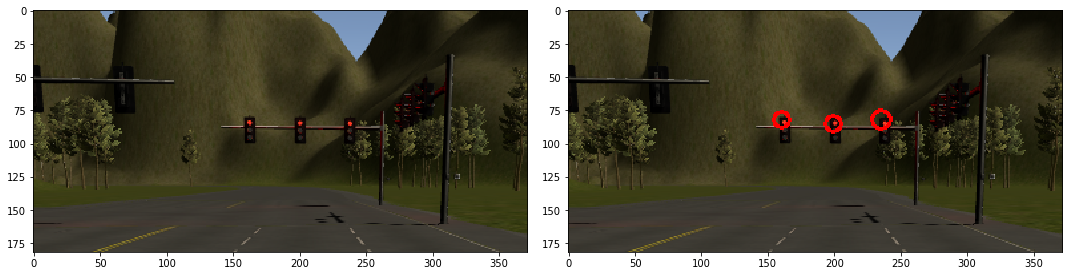

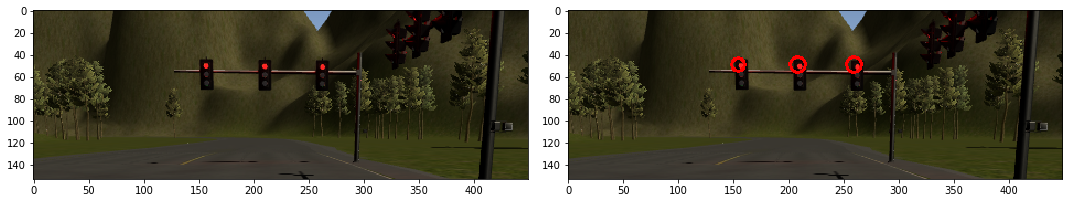

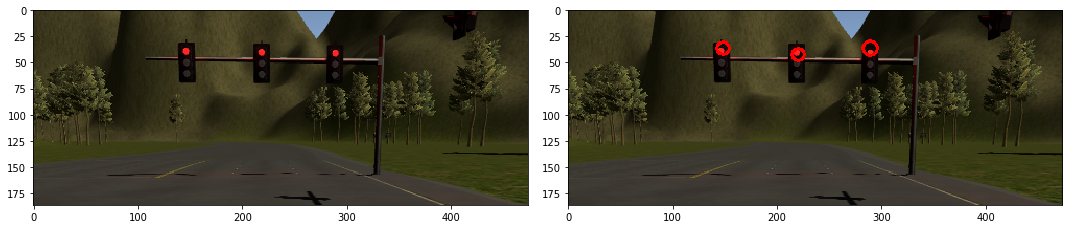

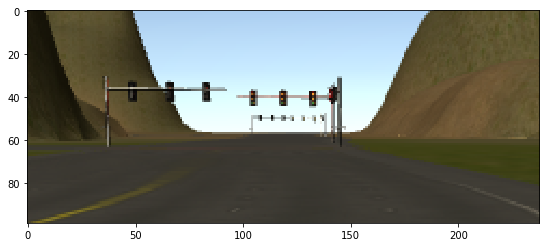

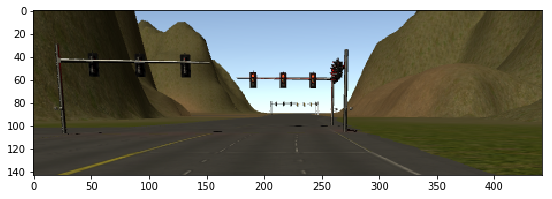

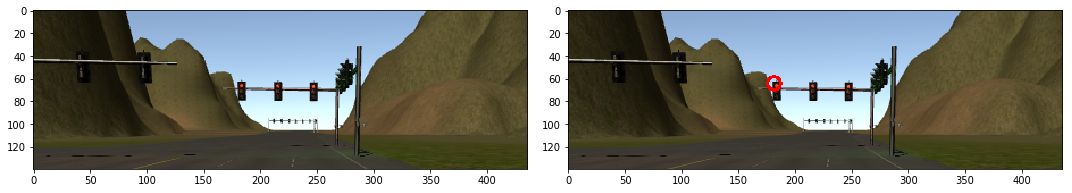

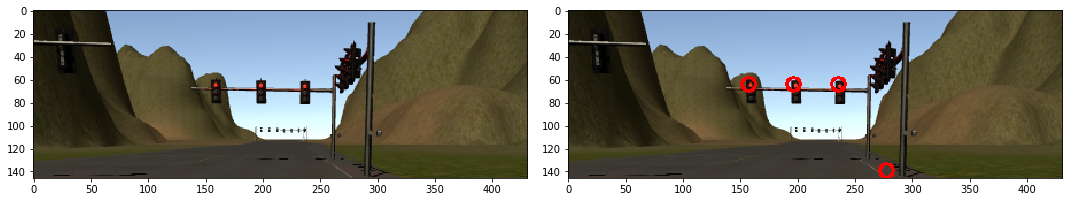

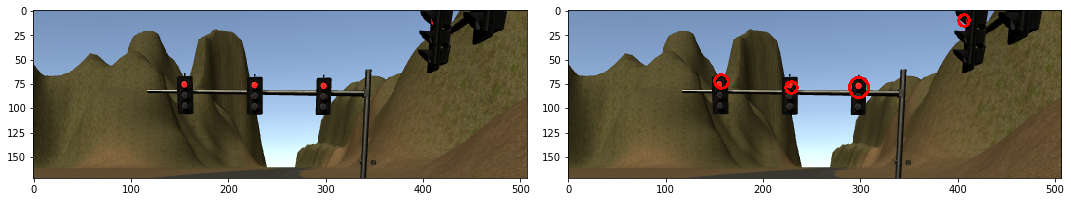

In [102]:
images = glob.glob('test_images/light_red*.png')

for file in (images):
    image =cv2.imread(file)
    
    #convert to hsv
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)  
    
    #detect light
    circles = recognize_red_light(hsv_image)
    
    #run hough circles
    #circles = get_hough_circles(weighted_image)
    #circles = cv2.HoughCircles(edges,cv2.HOUGH_GRADIENT,3,20,param1=20,param2=30,minRadius=5,maxRadius=40)
    
    #print(circles)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    #plt.imshow(weighted_image)

    plt.figure(figsize=(15, 15 ))
    plt.subplot(221)
    plt.imshow(image)
    if circles is not None:
        render_recognized_circles(image, circles, border_color=(255, 0, 0))
        plt.subplot(222)
        plt.imshow(image)
        
    plt.subplots_adjust(hspace = 1)
    plt.tight_layout()
    plt.show()



### Green Light detection

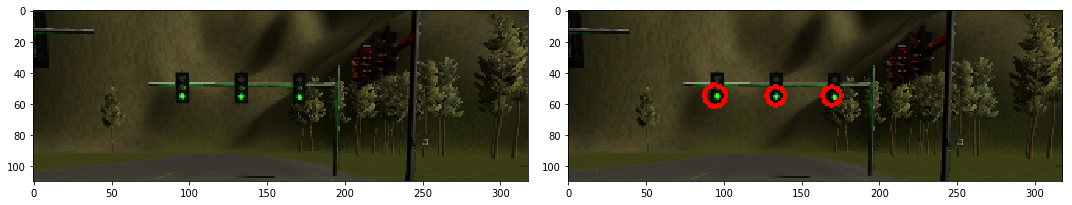

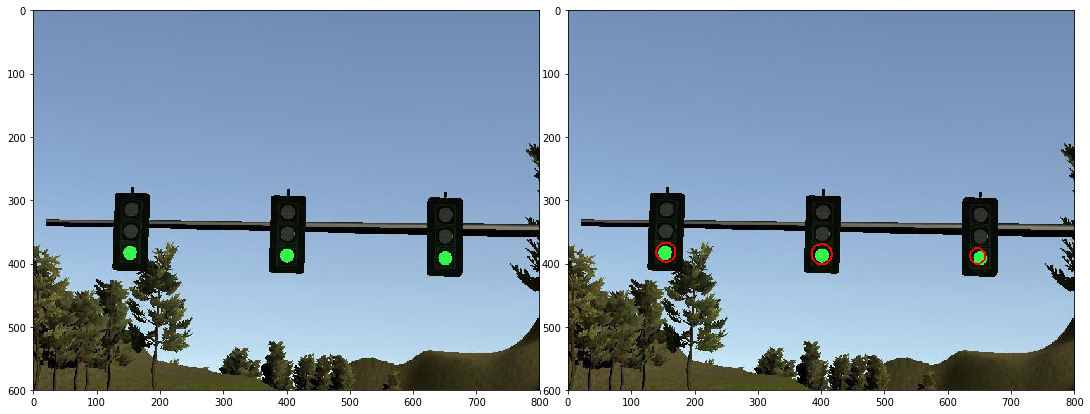

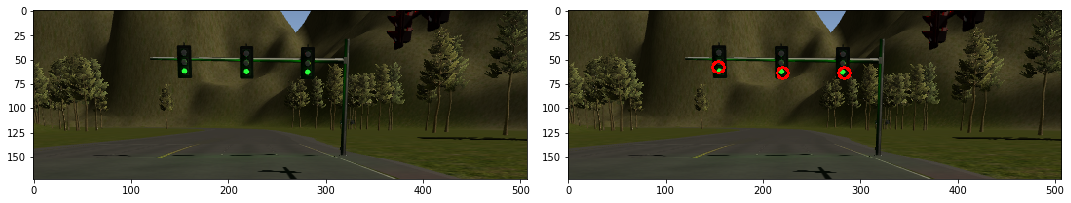

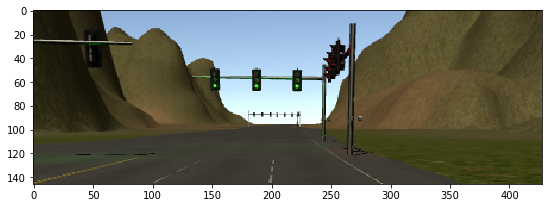

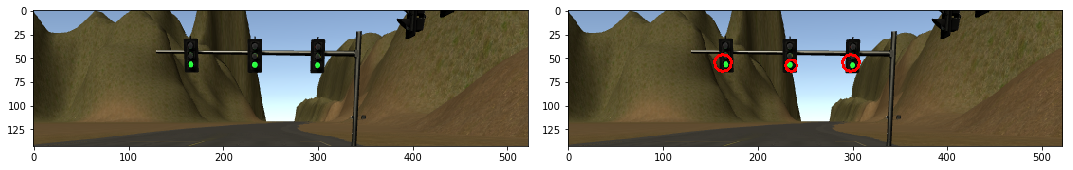

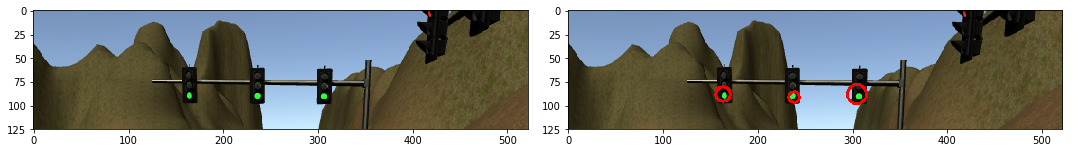

In [104]:
images = glob.glob('test_images/light_green*')

for file in (images):
    image =cv2.imread(file)
    
    #convert to hsv
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)  
    
    #detect light
    circles = recognize_green_light(hsv_image)
    
    #run hough circles
    #circles = get_hough_circles(weighted_image)
    #circles = cv2.HoughCircles(edges,cv2.HOUGH_GRADIENT,3,20,param1=20,param2=30,minRadius=5,maxRadius=40)
    
    #print(circles)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(15, 15 ))
    plt.subplot(221)
    plt.imshow(image)
    if circles is not None:
        render_recognized_circles(image, circles, border_color=(255, 0, 0))
        plt.subplot(222)
        plt.imshow(image)
        
    plt.subplots_adjust(hspace = 1)
    plt.tight_layout()
    plt.show()
